# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


#### initialize libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import numpy as np;           import pyproj
import datetime as dt;        import cartopy as cart
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import scipy.interpolate;     import cmocean
import seaborn as sns;        import geopandas as gpd
import matplotlib.tri as tri; import imageio
import pathlib as pl;         from sklearn.neighbors import BallTree
import xarray as xr;          

import cartopy.io.img_tiles as cimgt
from cartopy import config
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized

#### Initialize paths
---

In [3]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data

def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))
def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:float, satellite_lon:float): 
    rad_factor = np.pi/180.0
    modlatrad = model_lat[:] * rad_factor
    modlonrad = model_lon[:] * rad_factor
    ny,nx = modlatrad.shape, modlonrad.shape
    clat,clon = np.cos(modlatrad),np.cos(modlonrad)
    slat,slon = np.sin(modlatrad),np.sin(modlonrad)
    triples = list(zip(np.ravel(clat*clon), np.ravel(clat*slon), np.ravel(slat)))
    kdt = cKDTree(triples)
    #feeding the desired point
    satlatrad = satellite_lat * rad_factor
    satlonrad = satellite_lon * rad_factor
    clat0,clon0 = np.cos(satlatrad),np.cos(satlonrad)
    slat0,slon0 = np.sin(satlatrad),np.sin(satlonrad)
    dist_sq_min, minindex_1d = kdt.query([clat0*clon0, clat0*slon0, slat0])
    iy_min, ix_min = np.unravel_index(minindex_1d, modlatrad.shape), np.unravel_index(minindex_1d, modlonrad.shape)
    if iy_min != ix_min:
        print('Unmatching indexes! Something is wrong!')
    return iy_min #printing the index of nearest point
def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


In [4]:
start = pd.to_datetime('1979-01-01 00:00')
end = pd.to_datetime('2023-01-01 00:00')

In [5]:
root = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/40_year_simulation')
#tracks = gpd.read_file(root / 'miscellaneous/tracks/merged_tracks.shp')
name = '2018_v2'
ncfile = nc4.Dataset(root / name / 'outputs' / 'fort.63.nc')
dt = pd.date_range(start=pd.to_datetime(ncfile.variables['time'].base_date),freq='0.5h',periods=ncfile.variables['time'].shape[0])# + pd.to_timedelta('2 hour')
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

_____________________________________

In [6]:
station = 9497645
start,end = dt[0].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='6',product='predictions'))

TypeError: only integer scalar arrays can be converted to a scalar index

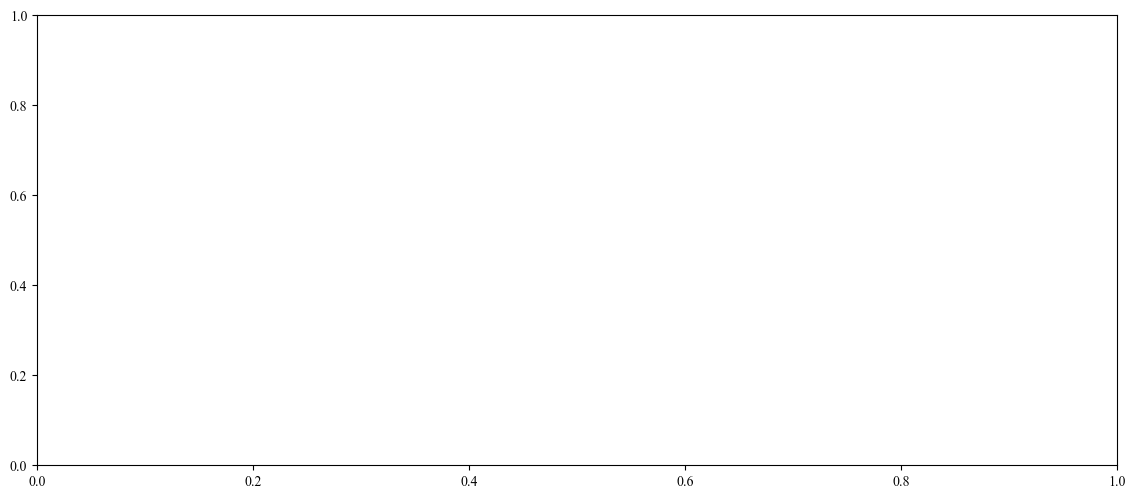

In [10]:

station = 9497645
start,end = dt[0].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='predictions'))
distances,node_ids = point_lookup(y, x,70.354964, -147.923999)
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(12,5))

ax = plt.axes([0,0.,0.9,.9])
dir = ['outputs']#,'outputs_icecube']
names = ['Ice']#, 'Ice']
colors = ['#00cc99','#ffcc66','#99cc00']
c=0
for d in dir:
    ncfile = nc4.Dataset(root / name / d / 'fort.63.nc')
    dt = pd.date_range(start=pd.to_datetime(ncfile.variables['time'].base_date),freq='1h',periods=ncfile.variables['time'].shape[0])
    
    c+=1
start,end = dt[0].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')
#file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='predictions'))
#pred=np.array([float(file['predictions'][i]['v']) for i in range(len(file['predictions']))])
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='hourly_height'))
obs =np.array([float(file['data'][i]['v']) for i in range(len(file['data']))])
surge = obs# - pred
model = np.mean(ncfile.variables['zeta'][:,node_ids[0][0]],obs)
ax.plot(dt,model,color=colors[c],label=names[c],linewidth=1.2)
ax.plot(pd.to_datetime([file['data'][i]['t'] for i in range(len(file['data']))]),
        surge,color='#7094db',label='NOAA',linewidth=0.8)

ax.set_ylabel(r'Surge [m at LMSL]',fontsize=14)
ax.set_ylim([-1.,1.000001])
ax.set_xlim([dt[0],dt[-1]])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
ax.set_title('Prudhoe Bay, AK')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/wl_red_v2.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [14]:
len(ncfile.variables['zeta'][:,node_ids[0][0]]),len(obs)

(6030, 6030)

In [13]:
np.mean(ncfile.variables['zeta'][:,node_ids[0][0]].data,obs)

TypeError: only integer scalar arrays can be converted to a scalar index

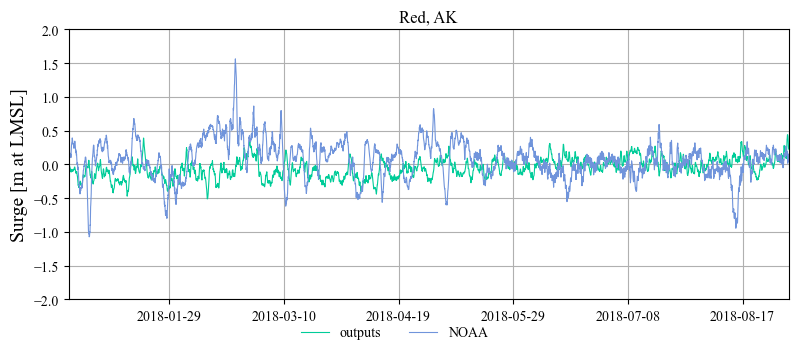

In [10]:
station = 9491094
start,end = dt[0].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')

distances,node_ids = point_lookup(y, x,67.570015, -164.088099)
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))

ax = plt.axes([0,0.,0.9,.9])
dir = ['outputs']#,'outputs_icecube']
colors = ['#00cc99','#ffcc66','#99cc00']
c=0
for d in dir:
    ncfile = nc4.Dataset(root / name / d / 'fort.63.nc')
    dt = pd.date_range(start=pd.to_datetime(ncfile.variables['time'].base_date),freq='1h',periods=ncfile.variables['time'].shape[0])
    ax.plot(dt,ncfile.variables['zeta'][:,node_ids[0][0]],color=colors[c],label=d.split('_')[-1],linewidth=0.8)
    c+=1
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='predictions'))
pred=np.array([float(file['predictions'][i]['v']) for i in range(len(file['predictions']))])
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='hourly_height'))
obs =np.array([float(file['data'][i]['v']) for i in range(len(file['data']))])
surge = obs-pred
ax.plot(pd.to_datetime([file['data'][i]['t'] for i in range(len(file['data']))]),
        surge,color='#7094db',label='NOAA',linewidth=0.8)

ax.set_ylabel(r'Surge [m at LMSL]',fontsize=14)
ax.set_ylim([-2.,2.000001])
ax.set_xlim([dt[0],dt[-1]])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
ax.set_title('Red, AK')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/wl_red_v2.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [5]:
pts = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/flood_events_2023/flood_events_2023.shp')
root = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/40_year_simulation')
tracks = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/model/climate/storm_tracks/era5_tracks_v4.shp')
domain = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/418-alaska-coastline-1-250-000/fat_coast.shp')

In [6]:
px,py = [geo.x for geo in pts.geometry],[geo.y for geo in pts.geometry]
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
distances,node_ids = point_lookup(y, x, py, px)

In [7]:
def find_area(x:np.array,y:np.array,px:float,py:float,step=0.15):
    poly = Polygon([(px-step,py-step),(px-step,py+step),(px+step,py+step),(px+step,py-step)])
    nodes = np.where(shapely.vectorized.contains(poly, x, y)==True)[0]
    return nodes


In [1]:
lat1,lat2 = 58,74
lon1,lon2 = -173, -142

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
#proj = ccrs.NorthPolarStereo(central_longitude=-145)
proj = ccrs.PlateCarree()
fig,axs = plt.subplots(
    1, 1, figsize=(7, 7), sharex=True, sharey=True,
    subplot_kw={'projection': proj, "aspect": 2},
    gridspec_kw = {'wspace':0.25, 'hspace':0.007},)
nodes = np.where(shapely.vectorized.contains(domain.geometry[0], x, y)==True)[0]
nodes2=[]
zeta = ncfile.variables['zeta'][:]
for n in nodes:
    if (y[n]<62) and (x[n]>-156):
        pass
    else:
        nodes2.append(n)

for p in pts.index:
    py,px = pts.geometry[p].y, pts.geometry[p].x
    if (py<62) and (px>-155):
        pass
    else:
        if (pts['flood_impa'][p]=='major') or (pts['flood_impa'][p]=='Major')\
             or (pts['flood_impa'][p]=='moderate'):
            color = '#00FFFFFF'
            nodes = find_area(x,y,px,py,step=0.1)
            if (pts['flood_impa'][p]=='major') or (pts['flood_impa'][p]=='Major'):
                #if np.max(zeta[:,nodes])>pts['height_m_n'][p]:
                color = '#ff4d4d'
            elif (pts['flood_impa'][p]=='moderate'):
                #if np.max(zeta[:,nodes])>pts['height_m_n'][p]:
                color = '#339966'
            nodes3=[]
            for n in nodes:
                if n in nodes2:
                    nodes3.append(n)

            m=axs.scatter(x[nodes3],y[nodes3],transform=ccrs.PlateCarree(),c=color,marker='.',s=50)#,edgecolors='k')

axs.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
#axs.coastlines(resolution='10m',linewidth=0.5)
axs.add_feature(cart.feature.LAKES)
axs.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
gl = axs.gridlines(xlocs=np.arange(-190,-100,10),ylocs=np.arange(-90,90,8),
                         draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                         y_inline=False,linestyle="--",zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right= True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8
url = 'https://server.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}.jpg'
request = cimgt.GoogleTiles(url=url)#style='street')

axs.add_image(request, 7,interpolation='bicubic')#,regrid_shape=3000)
#axs.legend((m,m2),('Major','Moderate'),loc='lower right', bbox_to_anchor=(.7, -.2),ncol=2,frameon=False,fontsize=10)
axs.set_title('Flood Impacts',fontsize=14)
plt.show()


NameError: name 'plt' is not defined

In [39]:
nodes

array([], dtype=int64)

In [ ]:
vd = vdg(ncfile.variables['zeta'][10,nodes], domain)

In [28]:
nodes3[0]

array([62175])

In [ ]:

lat1,lat2 = 58,74
lon1,lon2 = -173, -142

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
#proj = ccrs.NorthPolarStereo(central_longitude=-145)
proj = ccrs.PlateCarree()
fig,axs = plt.subplots(
    1, 1, figsize=(7, 7), sharex=True, sharey=True,
    subplot_kw={'projection': proj, "aspect": 2},
    gridspec_kw = {'wspace':0.25, 'hspace':0.007},)
pts2 = pts.loc[(pts['flood_impa']=='Major')]
for f in pts2.index:
    if ('Surge' in pts2['event_type'][f]) & (pd.to_datetime(pts2['date'][f]).year>=2000):
        for t in tracks.index:
            geo = tracks['geometry'][t]
            xp,yp = geo.xy
            start,end = pd.to_datetime(tracks['start'][t]),pd.to_datetime(tracks['end'][t])
            if (start<=pd.to_datetime(pts2['date'][f])) & (pd.to_datetime(pts2['date'][f])<end):
                axs.plot(xp,yp,transform = ccrs.PlateCarree(),color='#000000',linewidth=1.5)

        m=axs.scatter(pts2['geometry'][f].x,pts2['geometry'][f].y,transform=ccrs.PlateCarree(),c='#DC3220',marker='.',s=100,edgecolors='#595959')

pts2 = pts.loc[(pts['flood_impa']=='major')]
for f in pts2.index:
    if ('Surge' in pts2['event_type'][f]) & (pd.to_datetime(pts2['date'][f]).year>=2000):
        for t in tracks.index:
            geo = tracks['geometry'][t]
            xp,yp = geo.xy
            start,end = pd.to_datetime(tracks['start'][t]),pd.to_datetime(tracks['end'][t])
            if (start<=pd.to_datetime(pts2['date'][f])) & (pd.to_datetime(pts2['date'][f])<end):

                axs.plot(xp,yp,transform = ccrs.PlateCarree(),color='#000000',linewidth=1.5)
        m=axs.scatter(pts2['geometry'][f].x,pts2['geometry'][f].y,transform=ccrs.PlateCarree(),c='#DC3220',marker='.',s=100,edgecolors='#595959')      
pts2 = pts.loc[(pts['flood_impa']=='moderate')]
for f in pts2.index:
    if ('Surge' in pts2['event_type'][f]) & (pd.to_datetime(pts2['date'][f]).year>=2000):
        for t in tracks.index:
            geo = tracks['geometry'][t]
            xp,yp = geo.xy
            start,end = pd.to_datetime(tracks['start'][t]),pd.to_datetime(tracks['end'][t])
            if (start<=pd.to_datetime(pts2['date'][f])) & (pd.to_datetime(pts2['date'][f])<end):
                axs.plot(xp,yp,transform = ccrs.PlateCarree(),color='#000000',linewidth=1.5)
        m2=axs.scatter(pts2['geometry'][f].x*1.001,pts2['geometry'][f].y,transform=ccrs.PlateCarree(),c='#1F6879',marker='x',s=55,edgecolors='#595959')   
#m = axs.plot(xp,yp,transform = ccrs.PlateCarree(),color='#000000',linewidth=2.5)
axs.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
#axs.coastlines(resolution='10m',linewidth=0.5)
axs.add_feature(cart.feature.LAKES)
axs.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
gl = axs.gridlines(xlocs=np.arange(-190,-100,10),ylocs=np.arange(-90,90,8),
                         draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                         y_inline=False,linestyle="--",zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right= True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8
url = 'https://server.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}.jpg'
request = cimgt.GoogleTiles(url=url)#style='street')

axs.add_image(request, 7,interpolation='bicubic')#,regrid_shape=3000)
axs.legend((m,m2),('Major','Moderate'),loc='lower right', bbox_to_anchor=(.7, -.2),ncol=2,frameon=False,fontsize=10)
axs.set_title('Communities that had Moderate to Major Flooding after 2000',fontsize=14)
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/flood_stages_after2000.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [ ]:

stations = [9497645,9491094,9468756,9468333]
name = '2019_oct_dec'
for s in stations:
    start,end = dt[0].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')
    file = json.loads(noaa_data(start,end,s,vdatum='MSL',interval='h',product='hourly_height'))
    distances,node_ids = point_lookup(y, x,float(file['metadata']['lat']), float(file['metadata']['lon']))
    # -------------------------------------------------------------------------------------
    plt.rcParams["font.family"] = "Times New Roman"
    fig = plt.figure(figsize=(8,3))
    stat_name = file['metadata']['name']
    ax = plt.axes([0,0.,0.9,.9])
    dir = ['outputs_garratt','outputs_icecube']
    colors = ['#00cc99','#ffcc66','#99cc00']
    labels = ['No Ice', 'Ice']
    c=0
    for d in dir:
        ncfile = nc4.Dataset(root / name / d / 'fort.63.nc')
        dt = pd.date_range(start=pd.to_datetime(ncfile.variables['time'].base_date),freq='1h',periods=ncfile.variables['time'].shape[0])
        ax.plot(dt,ncfile.variables['zeta'][:,node_ids[0][0]],color=colors[c],label=labels[c],linewidth=1.2)
        c+=1

    file = json.loads(noaa_data(start,end,s,vdatum='MSL',interval='h',product='predictions'))
    pred=np.array([float(file['predictions'][i]['v']) for i in range(len(file['predictions']))])
    file = json.loads(noaa_data(start,end,s,vdatum='MSL',interval='h',product='hourly_height'))
    obs =np.array([float(file['data'][i]['v']) for i in range(len(file['data']))])
    surge = obs - pred
    ax.plot(pd.to_datetime([file['data'][i]['t'] for i in range(len(file['data']))]),
            surge,color='#7094db',label='NOAA',linewidth=0.8)

    ax.set_ylabel(r'Surge [m at LMSL]',fontsize=14)
    ax.set_ylim([-2.,2.000001])
    ax.set_xlim([dt[0],dt[-1]])
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
    ax.set_title(stat_name)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    plt.savefig(f'/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/surge_{stat_name}_v2.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
    plt.show()

In [ ]:
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='hourly_height'))

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
def omitcontours(cf):
    for level in cf.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            # go in reversed order due to deletions!
            # include test for "smallness" of your choice here:
            # I'm using a simple estimation for the diameter based on the
            #    x and y diameter...
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<2: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(
    return

In [ ]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 62,76
lon1,lon2 = -180, -135
start = '20191001 00:00'
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
wl = []
oceans = {'Chukchi Sea':{'x':-174.6,'y':69},'Beaufort Sea':{'x':-153,'y':72.7},'Arctic Ocean':{'x':-165,'y':76}}
proj = ccrs.NorthPolarStereo(central_longitude=-145)
begin,hours=0,len(dt)
cmap = cmocean.cm.deep_r
root = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/40_year_simulation/2019_oct_dec')
for i in np.arange(begin,hours,12):
    file_number = '%05d'%i
    fig = plt.figure(figsize=(10,9))    
    ax = plt.axes([0,0.,.95,.95],projection=proj)
    triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
    levels = np.arange(0,5,0.25)
    count=0
    ncfile = nc4.Dataset(root / 'outputs' /'swan_HS.63.nc')
    Z = ncfile['swan_HS'][i,:]
    if Z.mask.any():
        point_mask_indices = np.where(Z.mask)
        tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , point_mask_indices).reshape(-1, 3), axis=1)
        triang.set_mask(tri_mask)
    levels = np.arange(0,5,0.25)
    cf = ax.tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)
    levels = np.arange(0,100,25)
    ncfile = nc4.Dataset(root  / 'outputs' /'fort.93.nc')
    Z = ncfile['iceaf'][i,:]*100
    cf1 = ax.tricontour(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',colors = 'w', linewidths = 0.5)
    omitcontours(cf1)
    ax.clabel(cf1, inline=True, fontsize=8,fmt=fmt)
    ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    count+=1
    #cb = plt.colorbar(cf,cmap=cmap,fraction=0.025,pad=0.04) 
    #ax[count].clabel(cf, inline=True, fontsize=8,fmt=fmt)
    cbar_ax = fig.add_axes([1.,0.0198,0.025,0.935])
    cbar = fig.colorbar(cf,cax = cbar_ax, ticks=levels,orientation='vertical')
    cbar.set_label(label = r'$H_{S}$ [m]',fontsize =14)
    #cbar.ax.set_yticklabels(np.round(levels,2).astype(str))
    ax.coastlines(resolution='10m',linewidth=0.5)
    ax.add_feature(cart.feature.RIVERS,linestyle="-")
    ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
    for o in oceans.keys():
        ax.text(oceans[o]['x'],oceans[o]['y'],o,
                        transform = ccrs.PlateCarree(),color='#808080', fontsize=7)#,                
    gl = ax.gridlines(xlocs=np.arange(-190,-100,12.5),ylocs=np.arange(-90,90,3.5),
                                draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                                y_inline=False,linestyle="--",zorder=20)

    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.xlabel_style = {'rotation': 0}
    gl.ylabels_left = False
    gl.ylabels_right= True
    gl.ylabel_style = {'rotation': -90}
    gl.ypadding = 1.25
    gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
    gl.xpadding = 8
    ax.stock_img()
    plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/40_year_simulation/2019_oct_dec/outputs/WL{}.png'.format(file_number),bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
    plt.close()



path = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/40_year_simulation/2019_oct_dec/outputs')
wl = list(path.glob('WL*'))
wl.sort()    
writer = imageio.get_writer('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/40_year_simulation/2019_oct_dec/outputs/waves.mp4', format='FFMPEG',fps=10)
for im in wl:
    writer.append_data(imageio.imread(im))
writer.close()


In [ ]:
ncfile = nc4.Dataset(root / name / 'outputs' / 'fort.73.nc')
dt = pd.date_range(start=pd.to_datetime(ncfile.variables['time'].base_date),freq='1h',periods=ncfile.variables['time'].shape[0])# + pd.to_timedelta('2 hour')
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

In [ ]:
station = 9491094
start,end = dt[0].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='air_pressure'))

In [ ]:

distances,node_ids = point_lookup(y, x,float(file['metadata']['lat']),float(file['metadata']['lon']))
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))

ax = plt.axes([0,0.,0.9,.9])
ax.plot(dt,ncfile.variables['pressure'][:,node_ids[0][0]],color='#00cc66',label='Model')#*0.9714357692052295

ax.plot(pd.to_datetime([file['data'][i]['t'] if file['data'][i]['v']!='' else np.nan for i in range(len(file['data']))]),
        [float(file['data'][i]['v'])/100. if file['data'][i]['v']!='' else np.nan for i in range(len(file['data']))],color='#7094db',label='NOAA')

ax.set_ylabel(r'Pressure [kPa]',fontsize=14)
ax.set_ylim([9.0,11.000001])
ax.set_xlim([dt[100],dt[-1]])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
ax.set_title('St, AK')
#plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/pressure_stpaul.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [ ]:
noaa_data = [float(file['data'][i]['v'])/100. if file['data'][i]['v']!='' else np.nan for i in range(len(file['data']))]
modeldata = ncfile.variables['pressure'][:,node_ids[0][0]]
diff = np.abs(noaa_data-modeldata)/((noaa_data+modeldata)/2.)

In [ ]:
100-np.mean(diff*100)

In [ ]:
ncfile = nc4.Dataset(root / name / 'outputs2' / 'fort.74.nc')
dt = pd.date_range(start=pd.to_datetime(ncfile.variables['time'].base_date),freq='1h',periods=ncfile.variables['time'].shape[0]) + pd.to_timedelta('1 hour')

In [ ]:
station = 9497645
start,end = dt[10].strftime('%Y%m%d %H:%M'),dt[-1].strftime('%Y%m%d %H:%M')
file = json.loads(noaa_data(start,end,station,vdatum='MSL',interval='h',product='wind'))

In [ ]:

distances,node_ids = point_lookup(y, x,float(file['metadata']['lat']),float(file['metadata']['lon']))
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))

ax = plt.axes([0,0.,0.9,.9])
mag = np.sqrt(np.square(ncfile.variables['windx'][:,node_ids[0][0]])+np.square(ncfile.variables['windy'][:,node_ids[0][0]]))
ax.plot(dt,mag,color='#00cc66',label='Model',linewidth=0.8)

ax.plot(pd.to_datetime([file['data'][i]['t'] if file['data'][i]['s']!='' else np.nan for i in range(len(file['data']))]),
        [float(file['data'][i]['s']) if file['data'][i]['s']!='' else np.nan for i in range(len(file['data']))],color='#7094db',label='NOAA',linewidth=0.8)

ax.set_ylabel(r'Wind [m/s]',fontsize=14)
ax.set_ylim([0.0,35.000001])
ax.set_xlim([dt[4500],dt[-1]])
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
ax.set_title('Prudhoe Bay, AK')
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/wind_prudhoe.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [ ]:
pts = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/Coastal_Communities/Coastal_Communities2.shp')
pts = pts.sort_values('ID')
px,py = [geo.x for geo in pts.geometry],[geo.y for geo in pts.geometry]
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))
ax = plt.axes([0,0,1.,1.])
count = 1
directories = list(root.glob('ERA*'))

for d in directories[:]:
    if (d / 'outputs').exists():
        ncfile = nc4.Dataset(d / 'outputs' /'swan_HS.63.nc')
        x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
        distances,node_ids = point_lookup(y, x, py, px)
        Z = np.array([np.max(ncfile['swan_HS'][1:,node].data) for node in node_ids[:,0]])
        Z[Z<0]=0.01
        idx = tracks['Cyclone'][tracks['Cyclone'].str.contains(d.name)].index
        name = tracks['Month'][idx].values + ' ' + tracks['Type'][idx].values
        if 'ET' in tracks['Type'][idx].values:
            color = mpl.cm.Blues([count/5])
        elif 'AP' in tracks['Type'][idx].values:
            color = mpl.cm.Oranges([count/25])
        if ('June' in tracks['Month'][idx].values) or ('July' in tracks['Month'][idx].values) or\
        ('August' in tracks['Month'][idx].values):
            symbol = '+-'
        elif ('September' in tracks['Month'][idx].values) or ('October' in tracks['Month'][idx].values) or\
        ('November' in tracks['Month'][idx].values):
            symbol = '*-'
        elif ('December' in tracks['Month'][idx].values) or ('January' in tracks['Month'][idx].values) or\
        ('February' in tracks['Month'][idx].values):
            symbol = 's-'
        elif ('March' in tracks['Month'][idx].values) or ('April' in tracks['Month'][idx].values) or\
        ('May' in tracks['Month'][idx].values):
            symbol = 'd-'
        ax.plot(pts['CommunityN'].values,Z,symbol,color=color,linewidth=0.75,markersize=3,label=name[0])
        count+=1
    else:
        pass

ax.set_ylabel(r'$H_{S}$ [m]',fontsize=14)
ax.set_ylim([0,7.00001]),ax.set_xlim([0,len(pts)])
ax.xaxis.set_major_locator(plt.MaxNLocator(len(pts)))
ax.set_xmargin(10.25)
ax.set_xticklabels(pts['CommunityN'].values,rotation=90)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05),ncol=1,frameon=False,fontsize=10)
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/ak_coast_hs5.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [ ]:
pts = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/Coastal_Communities/Coastal_Communities2.shp')
pts = pts.sort_values('ID')
px,py = [geo.x for geo in pts.geometry],[geo.y for geo in pts.geometry]
plt.rcParams["font.family"] = "Times New Roman"
proj = ccrs.NorthPolarStereo(central_longitude=-145)
fig,axs = plt.subplots(
    2, 2, figsize=(4, 6), sharex=True, sharey=True,
    subplot_kw={"adjustable":"box", "aspect": 2},
    gridspec_kw = {'wspace':0.075, 'hspace':0.1},)

count = 1
directories = list(root.glob('ERA*'))

for d in directories[:]:
    if (d / 'outputs').exists():
        ncfile = nc4.Dataset(d / 'outputs' /'swan_HS.63.nc')
        x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
        distances,node_ids = point_lookup(y, x, py, px)
        Z = np.array([np.max(ncfile['swan_HS'][1:,node].data) for node in node_ids[:,0]])
        Z[Z<0]=0.01
        idx = tracks['Cyclone'][tracks['Cyclone'].str.contains(d.name)].index
        name = tracks['Month'][idx].values + ' ' + tracks['Type'][idx].values
        if 'ET' in tracks['Type'][idx].values:
            color = mpl.cm.Blues([count/5])
        elif 'AP' in tracks['Type'][idx].values:
            color = mpl.cm.Oranges([count/25])
        if ('June' in tracks['Month'][idx].values) or ('July' in tracks['Month'][idx].values) or\
        ('August' in tracks['Month'][idx].values):
            symbol = '+-'
            axs[0,0].plot(pts['CommunityN'].values,Z,symbol,color=color,linewidth=0.75,markersize=3,label=name[0])
            axs[0,0].set_title('Summer',fontsize=10)
        elif ('September' in tracks['Month'][idx].values) or ('October' in tracks['Month'][idx].values) or\
        ('November' in tracks['Month'][idx].values):
            symbol = '*-'
            axs[0,1].plot(pts['CommunityN'].values,Z,symbol,color=color,linewidth=0.75,markersize=3,label=name[0])
            axs[0,1].set_title('Fall',fontsize=10)
        elif ('December' in tracks['Month'][idx].values) or ('January' in tracks['Month'][idx].values) or\
        ('February' in tracks['Month'][idx].values):
            symbol = 's-'
            axs[1,0].plot(pts['CommunityN'].values,Z,symbol,color=color,linewidth=0.75,markersize=3,label=name[0])
            axs[1,0].set_title('Winter',fontsize=10)
        elif ('March' in tracks['Month'][idx].values) or ('April' in tracks['Month'][idx].values) or\
        ('May' in tracks['Month'][idx].values):
            symbol = 'd-'
            axs[1,1].plot(pts['CommunityN'].values,Z,symbol,color=color,linewidth=0.75,markersize=3,label=name[0])
            axs[1,1].set_title('Spring',fontsize=10)
        
        count+=1
    else:
        pass
axs[1,0].set_xticklabels(pts['CommunityN'].values,rotation=90),axs[1,1].set_xticklabels(pts['CommunityN'].values,rotation=90)
axs[0,0].set_ylabel(r'$H_{S}$ [m]',fontsize=14),axs[1,0].set_ylabel(r'$H_{S}$ [m]',fontsize=14)
for i in [0,1]:
    for ii in [0,1]:
        axs[i,ii].set_ylim([0,7.00001]),axs[i,ii].set_xlim([0,len(pts)])
        axs[i,ii].xaxis.set_major_locator(plt.MaxNLocator(len(pts)))
        axs[i,ii].set_xmargin(10.25)
        axs[i,ii].grid(True)

#axs[0,0].legend(loc='upper right', bbox_to_anchor=(1.25, 1.05),ncol=1,frameon=False,fontsize=10)
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/ak_coast_season_hs2.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()

In [ ]:
pts = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/Coastal_Communities/Coastal_Communities2.shp')
px,py = [geo.x for geo in pts.geometry],[geo.y for geo in pts.geometry]
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))
ax = plt.axes([0,0,1.,1.])
count = 1
directories = list(root.glob('ERA*'))

for d in directories[:]:
    if (d / 'outputs').exists():
        ncfile = nc4.Dataset(d / 'outputs' /'fort.63.nc')
        x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
        distances,node_ids = point_lookup(y, x, py, px)
        Z = np.array([np.max(ncfile['zeta'][1:,node].data) for node in node_ids[:,0]])
        Z[Z<0]=0.01
        idx = tracks['Cyclone'][tracks['Cyclone'].str.contains(d.name)].index
        name = tracks['Month'][idx].values + ' ' + tracks['Type'][idx].values
        if 'ET' in tracks['Type'][idx].values:
            color = mpl.cm.Blues([count/5])
        elif 'AP' in tracks['Type'][idx].values:
            color = mpl.cm.Oranges([count/25])
        if ('June' in tracks['Month'][idx].values) or ('July' in tracks['Month'][idx].values) or\
        ('August' in tracks['Month'][idx].values):
            symbol = '+-'
        elif ('September' in tracks['Month'][idx].values) or ('October' in tracks['Month'][idx].values) or\
        ('November' in tracks['Month'][idx].values):
            symbol = '*-'
        elif ('December' in tracks['Month'][idx].values) or ('January' in tracks['Month'][idx].values) or\
        ('February' in tracks['Month'][idx].values):
            symbol = 's-'
        elif ('March' in tracks['Month'][idx].values) or ('April' in tracks['Month'][idx].values) or\
        ('May' in tracks['Month'][idx].values):
            symbol = 'd-'
        ax.plot(pts['CommunityN'].values,Z,symbol,color=color,linewidth=0.75,markersize=3,label=name[0])
        count+=1
    else:
        pass

ax.set_ylabel(r'Water Surface Elevation [m at LMSL]',fontsize=14)
ax.set_ylim([0,5.00001]),ax.set_xlim([0,len(pts)])
ax.xaxis.set_major_locator(plt.MaxNLocator(len(pts)))
ax.set_xmargin(10.25)
ax.set_xticklabels(pts['CommunityN'].values,rotation=90)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.05),ncol=1,frameon=False,fontsize=10)
plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/ak_coast_surge1.png',bbox_inches='tight',pad_inches=0.1, dpi=600, transparent=True)
plt.show()